# Working out if we can tractably perform optimality experiments with the effective radius of a knn graph vs. number of samples vs. testing out if we get an interesting probability.

Given runtime (and sometimes space) constraints on compute cluster, we can only build knn-graphs with ~500 neighbors (see notes on some quick `kgraph` tests).

This notebook is to do some sanity experiments and calculations to ensure that these experiments are runnable. We do the following:

- [ ] Graph/table the Sauer-Shelah bound curve to see how many samples are required to hit certain probabilities.  

- [ ] Run the KNN version of the PRM a certain number of times to determine the concentration of the effective connection radius for varying numbers of sampling (in the exact environment we intend to run them in).

We'll compare these results and draw some conclusions at the end of the document.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True})

from nonasymptotic.bound import * 
from nonasymptotic.envs import StraightLine
from nonasymptotic.prm import SimpleNearestNeighborRadiusPRM

seed = 1999

Dimensions correspond with common robot DofS (planar, planar + angle, arm on base, two arms, PR2).

In [2]:
# Specify the dimensions and sample counts we intend to test (only add in the 1e5/1e6 if we run this on supercloud).
ds = np.array([2, 3, 7, 10, 14, 20])
sample_counts = np.array([1e2, 1e3, 1e4], dtype=np.int32) # int(1e5), int(1e6) 

We'll be conducting these sanity-checking experiments in the exact environment we'll be evaluating them in: simple box environments $[-0.5, 1.5] \times [-0.5, 0.5]^{d-1}$, (we chose $\delta = 0.5$ so that the volume of the whole environment does not change between dimensions).

In [3]:
# construct environments
clearance = 0.5
envs = [StraightLine(_d, clearance, seed) for _d in ds]

Since these are optimality experiments, we should get a numerical sense of the $\epsilon \mapsto r_{conn}$ mapping. It is important to note that we lose 1-to-1 mapping when we shoot past 1 ($\epsilon$ is really only meant to be small, e.g. $<1$), so that's why we do this range. 

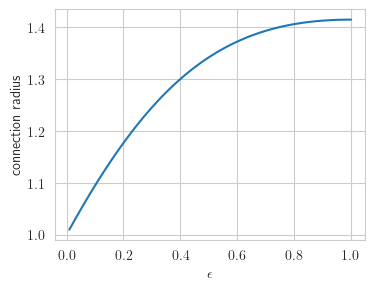

In [4]:
tols = np.linspace(1.0, 0.01, num=100)
conn_rads = compute_connection_radius(clearance, tols)

plt.figure(figsize=(4,3))
plt.plot(tols, conn_rads)
plt.xlabel('$\epsilon$')
plt.ylabel('connection radius')
plt.show()

So we're looking to have connection radii between the 1 -> 1.4 range.

Next, we'll zoom in on the kinds of $\epsilon$-nets we need to have, and how many samples (as predicted by Sauer-Shelah) we need to hit them (with an interesting range of hittable probabilities).

First (since this is a dimension-free quantity) -- the radius of the balls on the $\epsilon$-nets.

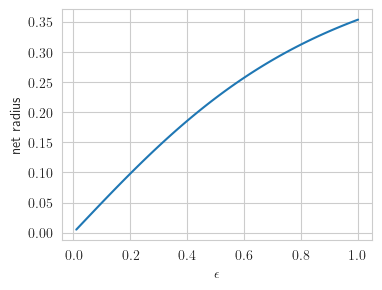

In [5]:
net_rads = compute_epsilon_net_radius(clearance, tols)

plt.figure(figsize=(4,3))
plt.plot(tols, net_rads)
plt.xlabel('$\epsilon$')
plt.ylabel('net radius')
plt.show()

This looks tiny... a bit worried here. But we press on to find out.

We first compute the required rhos for each dimension, and then we zoom in (interesting ranges) of Sauer-Shelah.

In [6]:
vols_env = np.array([_e.volume for _e in envs])

# we could probably vectorize in a meshgrid, but for sanity, we just do dimension-by-dimension
# rhos = compute_rho(clearance, tols, ds, vols_env)

ValueError: operands could not be broadcast together with shapes (100,) (6,) 